In [2]:
import aocd
import re
from dotenv import load_dotenv
import numpy as np
from tqdm import tqdm
import networkx as nx

load_dotenv()

puzzle = aocd.get_puzzle(day=21, year=2024)
text = puzzle.input_data
examples = puzzle.examples

lines = text.splitlines()

example = examples[0].input_data.splitlines()

print(text)

286A
974A
189A
802A
805A


In [2]:
text = """029A
980A
179A
456A
379A
"""
lines = text.splitlines()

text

'029A\n980A\n179A\n456A\n379A\n'

^ 2 KeysView(AtlasView({'A': {'val': '>'}, 'v': {'val': 'v'}}))
v 3 KeysView(AtlasView({'>': {'val': '>'}, '^': {'val': '^'}, '<': {'val': '<'}}))
< 1 KeysView(AtlasView({'v': {'val': '>'}}))
> 2 KeysView(AtlasView({'A': {'val': '^'}, 'v': {'val': '<'}}))
A 2 KeysView(AtlasView({'^': {'val': '<'}, '>': {'val': 'v'}}))


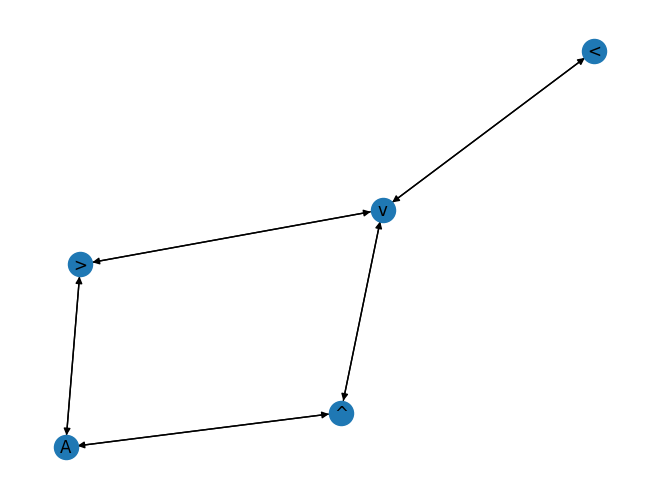

In [3]:
k1 = nx.DiGraph()

for i in list(range(10))+ ["A"]:
    k1.add_node(i)

k1.add_edge("A", 0, val="<")
k1.add_edge(0, "A", val=">")
k1.add_edge("A", 3, val="^")
k1.add_edge(3, "A", val="v")
k1.add_edge(0,2, val="^")
k1.add_edge(2,0, val="v")
k1.add_edge(2,3, val=">")
k1.add_edge(3,2, val="<")
k1.add_edge(2,1, val="<")
k1.add_edge(1,2, val=">")
k1.add_edge(2,5, val="^")
k1.add_edge(5,2, val="v")
k1.add_edge(3,6, val="^")
k1.add_edge(6,3, val="v")
k1.add_edge(6,5, val="<")
k1.add_edge(5,6, val=">")
k1.add_edge(5,4, val="<")
k1.add_edge(4,5, val=">")
k1.add_edge(5,8, val="^")
k1.add_edge(8,5, val="v")
k1.add_edge(1,4, val="^")
k1.add_edge(4,1, val="v")
k1.add_edge(4,7, val="^")
k1.add_edge(7,4, val="v")
k1.add_edge(7,8, val=">")
k1.add_edge(8,7, val="<")
k1.add_edge(8,9, val=">")
k1.add_edge(9,8, val="<")
k1.add_edge(9,6, val="v")
k1.add_edge(6,9, val="^")

k2 = nx.DiGraph()
k2.add_nodes_from(["^", "v", "<", ">", "A"])
k2.add_edge("A", "^", val="<")
k2.add_edge("^", "A", val=">")
k2.add_edge("A", ">", val="v")
k2.add_edge(">", "A", val="^")
k2.add_edge(">", "v", val="<")
k2.add_edge("v", ">", val=">")
k2.add_edge("v", "^", val="^")
k2.add_edge("^", "v", val="v")
k2.add_edge("v", "<", val="<")
k2.add_edge("<", "v", val=">")


for n in k2.nodes:
    print(n, len(k2[n].keys()), k2[n].keys())

nx.draw(k2, with_labels=True)

In [14]:
import re

from itertools import tee, product
def pairwise(it):
    a, b = tee(it)
    next(b, None)
    return zip(a, b)

def chain(a,b):
    for aa, bb in zip(a,b):
        yield aa
        yield bb

def f(s):
    if s in "A^v<>":
        return s
    return int(s)

def line2seqs(line, k):
    line = "A" + line.removeprefix("A")
    ret = []
    for a, b in pairwise(line):
        buffs = []
        paths = nx.all_shortest_paths(k, f(a), f(b))
        for path in paths:            
            buff = ""
            for e in pairwise(path):
                buff += k[e[0]][e[1]]["val"]
            buffs.append(buff)
        ret.append(buffs)   

    res = []
    for t in product(*ret):
        res.append("A".join(t)+"A")

    return res

def four_levels(line):
    l1s = line2seqs(line, k1)

    
    l2s = []
    for l1 in l1s:
        l2s += line2seqs(l1, k2)


    l3 = []
    for l2 in l2s:
        l3 += line2seqs(l2, k2)
    return min([len(l) for l in l3])
    

s = 0
for line in lines:
    numeric = int(re.sub(r"[A-Z]", "", line))
    length = four_levels(line)
    c = numeric * length
    s += c
    print(numeric, length, c)

print(s)

286 68 19448
974 72 70128
189 74 13986
802 70 56140
805 72 57960
217662


In [11]:
from collections import Counter

class BetterCounter(Counter):
    def __mul__(self, factor):
        if not isinstance(factor, int):
            raise ValueError("Can only multiply by an integer")
        return BetterCounter({k: v * factor for k, v in self.items()})
    
    def __rmul__(self, factor):
        return self * factor
    
    def __add__(self, other):
        return BetterCounter(super().__add__(other))
    
    def __sub__(self, other):
        c = self.copy()
        c.subtract(other)
        return c

def count(line):
    return BetterCounter([a+b for a,b in pairwise(line)])

def count_change(s):
    a = np.array(list(s))
    return int((a[1:] != a[:-1]).sum())

order_dict = {char: i for i, char in enumerate("<v^>A")}
def lexical_key(s):
    return [order_dict[char] for char in s]



def one_level(counter, k):
    c = BetterCounter()
    for (a,b), v in counter.items():
        paths = nx.all_shortest_paths(k, f(a), f(b))
        paths_str = ["".join([k[e[0]][e[1]]["val"] for e in pairwise(path)]) for path in paths]        
        sorted_str = sorted(paths_str, key=lambda s: (count_change(s), lexical_key(s)))
        s0 = sorted_str[0]
        
        s = "A" + s0 + "A"
        c.update(count(s) * v)
    return c


def n_levels(line, n=25):
    l0 = "A" + line
    c0 = count(l0)
    c = one_level(c0, k1)
    for _ in range(n):
        c = one_level(c, k2)
    return c

def puzzle(n):
    s = 0
    for line in lines:
        numeric = int(re.sub(r"[A-Z]", "", line))
        length = n_levels(line, n).total()
        c = numeric * length
        s += c
        print(numeric, length, c)
    return s

print(puzzle(2))
print(puzzle(25))




286 68 19448
974 72 70128
189 74 13986
802 70 56140
805 72 57960
217662
286 86475783008 24732073940288
974 85006969638 82796788427412
189 90594397580 17122341142620
802 86475783010 69353577974020
805 86475783012 69613005324660
263617786809000


In [8]:
aocd.submit(s, day=21, year=2024)

current_day is only available in December (EST)
answer a: 217662
submitting for part b (part a is already completed)


That's the right answer!  You are one gold star closer to finding the Chief Historian.You have completed Day 21! You can [Shareon
  Bluesky
Twitter
Mastodon] this victory or [Return to Your Advent Calendar].


Gtk-Message: 14:29:28.976: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
